# Import Required Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools

In [2]:
# Load the data
data = pd.read_csv('Arrival.csv')

In [3]:
data

,Arrivals,Date,Employee_payday,Pension_payday,After_or_before_holiday,Monday,Tuesday,Wednesday,Thursday,Friday
0,1825,1/2,1,1,1,0,1,0,0,0
1,1257,1/3,0,0,0,0,0,1,0,0
2,969,1/4,0,0,0,0,0,0,1,0
3,1672,1/5,1,0,0,0,0,0,0,1
4,1098,1/8,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
249,941,12/24,0,0,1,1,0,0,0,0
250,999,12/26,0,0,1,0,0,1,0,0
251,619,12/27,0,0,0,0,0,0,1,0
252,937,12/28,0,0,0,0,0,0,0,1


# Formatting & Indexing the Dataset

In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d')

In [5]:
# Format dates to display only month and day
data['Date'] = data['Date'].apply(lambda x: x.strftime('%m-%d'))

In [6]:
data.set_index('Date', inplace=True)

In [7]:
data.isnull().sum()

Arrivals                   0
Employee_payday            0
Pension_payday             0
After_or_before_holiday    0
Monday                     0
Tuesday                    0
Wednesday                  0
Thursday                   0
Friday                     0
dtype: int64

In [8]:
data.dtypes

Arrivals                   int64
Employee_payday            int64
Pension_payday             int64
After_or_before_holiday    int64
Monday                     int64
Tuesday                    int64
Wednesday                  int64
Thursday                   int64
Friday                     int64
dtype: object

# Checking The Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(data['Arrivals'])

# Print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Check if the data is stationary based on the p-value
if adf_result[1] < 0.05:
    print("The data is stationary (reject the null hypothesis of non-stationarity)")
else:
    print("The data is non-stationary (fail to reject the null hypothesis of non-stationarity)")


ADF Statistic: -3.8447380756163825
p-value: 0.0024813596014064384
Critical Values:
   1%: -3.4575505077947746
   5%: -2.8735087323013526
   10%: -2.573148434859185
The data is stationary (reject the null hypothesis of non-stationarity)


# Plotting ACF & PACF plot

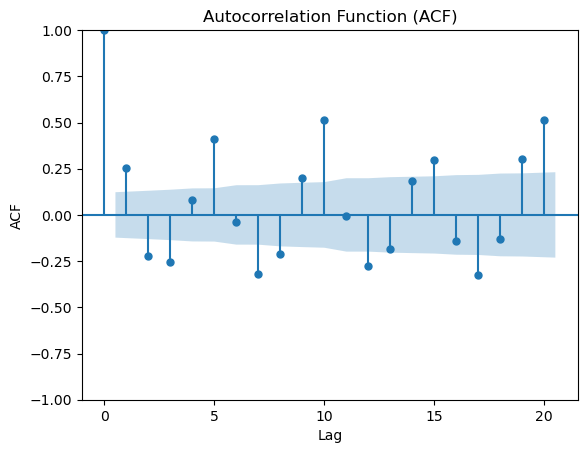

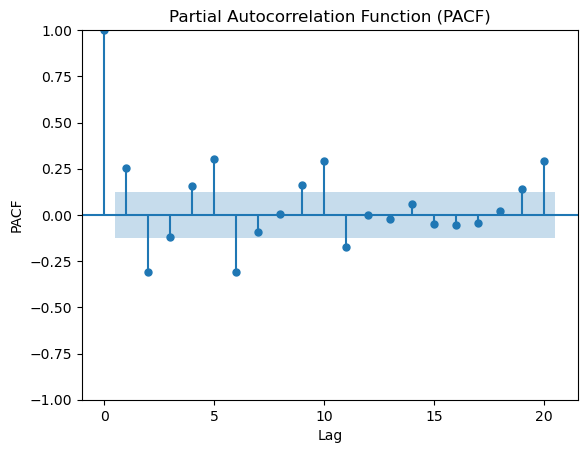

In [10]:
ts = data['Arrivals']

# Plot ACF
plot_acf(ts, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Plot PACF
plot_pacf(ts, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()


# Checking The Seasonality & Trend

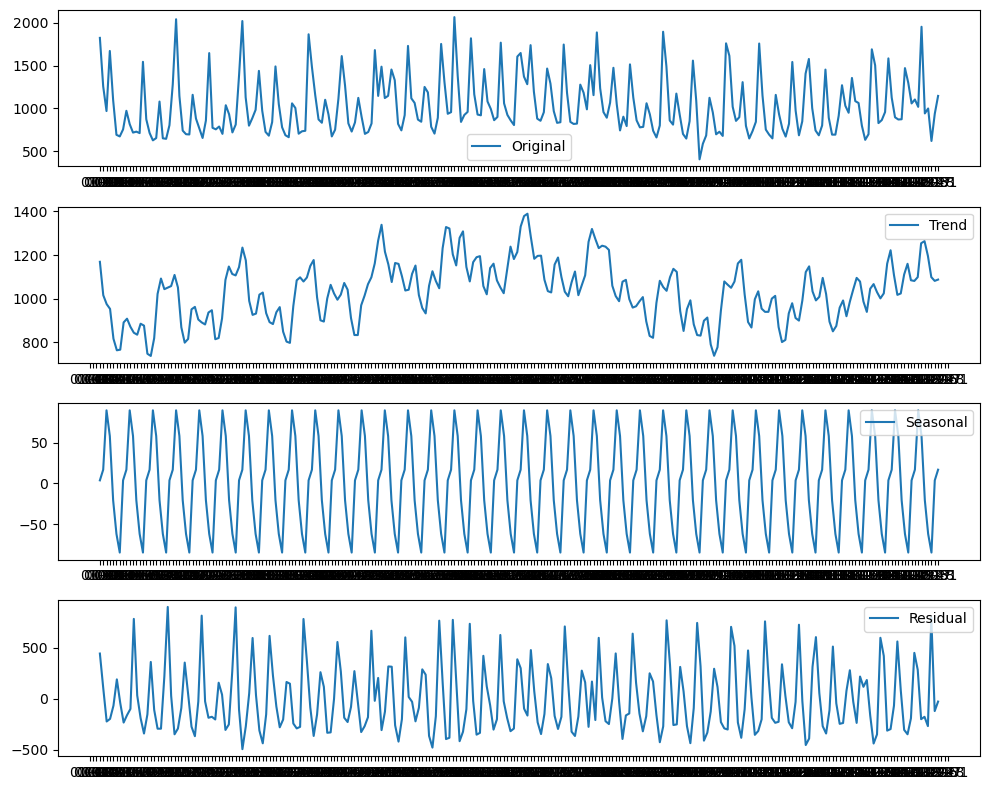

In [11]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period = 7)  # Assuming Weekly seasonality for  data

# Plot the decomposition components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(ts, label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

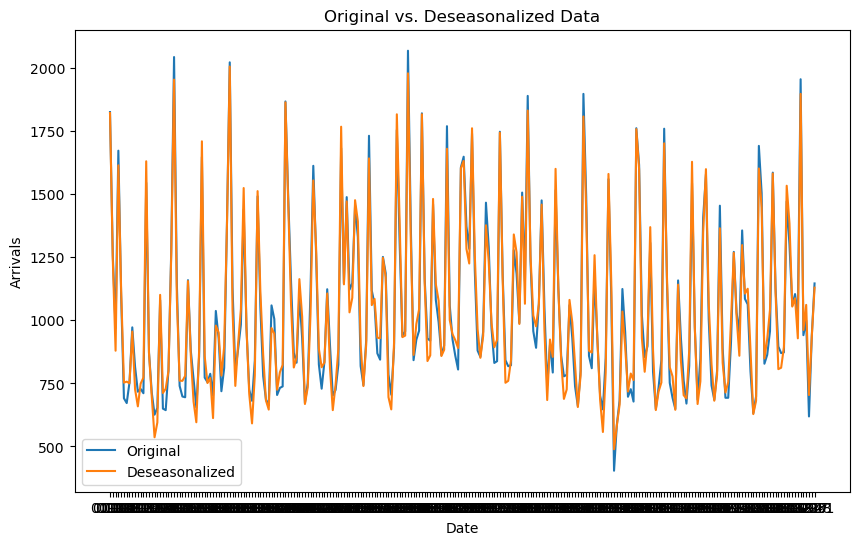

In [12]:
# Obtain seasonal component
seasonal_component = decomposition.seasonal

# Deseasonalize data
deseasonalized_data = ts - seasonal_component

# Plot original and deseasonalized data for comparison
plt.figure(figsize=(10, 6))
plt.plot(data.index, ts, label='Original')
plt.plot(data.index, deseasonalized_data, label='Deseasonalized')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.title('Original vs. Deseasonalized Data')
plt.legend()
plt.show()

In [13]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")
# Define exogenous variables and target variable
exog_vars = data.columns.tolist()
exog_vars.remove('Arrivals')  # Remove the target variable from exogenous variables

# Finding The best p,d,q combinations minimizing the AIC, BIC.

In [14]:
''' This portion Will take some times as it will check 6 * 6 * 2 = 72 combinations to find the best combination that
has less AIC, BIC'''

# Define range of p, d, q values
p_values = range(0, 6)  # Example range for p
d_values = range(0, 6)  # Example range for d
q_values = range(0, 2)  # Example range for q

# Generate all possible combinations of p, d, q
pdq_combinations = list(itertools.product(p_values, d_values, q_values))
# Initialize lists to store AIC and BIC values
aic_values = []
bic_values = []

# Grid search over combinations of p, d, q
for pdq in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(endog=deseasonalized_data, exog=data[exog_vars], order=pdq)
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
        bic_values.append(model_fit.bic)
    except:
        continue

# Find the best combination based on AIC and BIC criteria
best_aic = min(aic_values)
best_bic = min(bic_values)
best_pdq_aic = pdq_combinations[aic_values.index(best_aic)]
best_pdq_bic = pdq_combinations[bic_values.index(best_bic)]

print("Best AIC:", best_aic)
print("Best parameters (AIC):", best_pdq_aic)
print("Best BIC:", best_bic)
print("Best parameters (BIC):", best_pdq_bic)

Best AIC: 3300.0112629554774
Best parameters (AIC): (1, 1, 1)
Best BIC: 3338.87854733148
Best parameters (BIC): (1, 1, 1)


# Model With Original Data 

In [15]:
model_real = sm.tsa.ARIMA(endog=data['Arrivals'], exog=data[exog_vars], order=(1, 1, 1))
results_real = model_real.fit()
print(results_real.summary())

                               SARIMAX Results                                
Dep. Variable:               Arrivals   No. Observations:                  254
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1637.054
Date:                Fri, 03 May 2024   AIC                           3296.108
Time:                        23:55:08   BIC                           3334.975
Sample:                             0   HQIC                          3311.745
                                - 254                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Employee_payday           346.2073     32.137     10.773      0.000     283.220     409.194
Pension_payday            259.0966     28.332      9.145      0.000     203.566     314.627


In [16]:
# Define the number of steps to forecast
forecast_steps = 254  # Adjust as needed

# Generate exogenous variables for forecasting
forecast_exog = data[exog_vars].iloc[-forecast_steps:]  # Use the last values of exogenous variables

# Forecast future values
forecast_real = results_real.forecast(steps=forecast_steps, exog=forecast_exog)

# Print forecasted values
print("Forecasted Values:")
print(forecast_real)

Forecasted Values:
254    1676.105333
255     837.941654
256     861.295564
257    1653.255787
258    1088.412344
          ...     
503    1291.773932
504    1029.568936
505     855.114835
506    1304.134230
507    1087.038242
Name: predicted_mean, Length: 254, dtype: float64


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


actual_values = ts
# Calculate forecasted values
forecast_values = results_real.forecast(steps=len(actual_values), exog=forecast_exog)

# Calculate accuracy metrics
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)

# Print accuracy metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Absolute Error (MAE): 140.91011028338247
Mean Squared Error (MSE): 33354.20287871024
Root Mean Squared Error (RMSE): 182.63133049592076


# Model With Deseasonalized Data

In [18]:
model_deseason = sm.tsa.ARIMA(endog=deseasonalized_data, exog=data[exog_vars], order=(1, 1, 1))
results_deseason = model_deseason.fit()
print(results_deseason.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1639.006
Date:                Fri, 03 May 2024   AIC                           3300.011
Time:                        23:55:09   BIC                           3338.879
Sample:                             0   HQIC                          3315.649
                                - 254                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Employee_payday           341.6800     33.368     10.240      0.000     276.279     407.081
Pension_payday            248.7878     29.604      8.404      0.000     190.765     306.811


In [19]:
# Forecast future values
forecast_deseason = results_deseason.forecast(steps=forecast_steps, exog=forecast_exog)
# Print forecasted values
print("Forecasted Values:")
print(forecast_deseason)


Forecasted Values:
254    1656.784976
255     835.782931
256     865.914112
257    1648.902192
258    1089.712794
          ...     
503    1292.839322
504    1031.790484
505     862.493927
506    1305.718633
507    1089.051806
Name: predicted_mean, Length: 254, dtype: float64


In [20]:
# Calculate forecasted values
forecast_values_1 = results_deseason.forecast(steps=len(actual_values), exog=forecast_exog)

# Calculate accuracy metrics
mae = mean_absolute_error(actual_values, forecast_values_1)
mse = mean_squared_error(actual_values, forecast_values_1)
rmse = np.sqrt(mse)

# Print accuracy metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 141.80705215016692
Mean Squared Error (MSE): 33536.44803322416
Root Mean Squared Error (RMSE): 183.12959354845998
